In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # plotting library
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# libraries for displaying images
from IPython.display import Image
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [2]:
# read data file
df = pd.read_csv('mrt_lrt_data2.csv')
df.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [3]:
# Basic type information about data
df.dtypes

station_name     object
type             object
lat             float64
lng             float64
dtype: object

In [4]:
#check number of LRT and MRT stations
df_group = df.groupby('type').count()
df_group

,station_name,lat,lng
type,,,
LRT,38,38,38
MRT,119,119,119


In [5]:
#Get MRT data into new dataframe - confine analysis to MRT stations
df_MRT = df.loc[df['type'] == 'MRT']
df_MRT.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [6]:
# check size of MRT data
df_MRT.shape

(119, 4)

In [7]:
# create map of MRT stations using latitude and longitude values
latitude = 1.333207
longitude = 103.742308
map_stations = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(df_MRT['lat'], df_MRT['lng'], df_MRT['station_name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_stations)
map_stations

In [8]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P' # your Foursquare ID
CLIENT_SECRET = 'SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P
CLIENT_SECRET:SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB


In [9]:
#first station locaton 
df_MRT.loc[0, 'station_name']

'Jurong East'

In [10]:
#get latitude and longitude of Jurong East
station_latitude = df_MRT.loc[0, 'lat'] # station latitude value
station_longitude = df_MRT.loc[0, 'lng'] # station longitude value
station_name = df_MRT.loc[0, 'station_name'] # station name
print('Latitude and longitude values of {} are {}, {}.'.format(station_name, station_latitude, station_longitude))

Latitude and longitude values of Jurong East are 1.333207, 103.742308.


In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    station_latitude,
    station_longitude,
    radius,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P&client_secret=SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB&v=20180605&ll=1.333207,103.742308&radius=500&limit=100'

In [12]:
results = requests.get(url).json() #get results
results

{'meta': {'code': 200, 'requestId': '5e78d0ed95feaf001bc07432'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jurong East',
  'headerFullLocation': 'Jurong East, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 73,
  'suggestedBounds': {'ne': {'lat': 1.3377070045000046,
    'lng': 103.74680081871648},
   'sw': {'lat': 1.3287069954999955, 'lng': 103.73781518128351}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51c0356c498e19c820f5e48e',
       'name': 'UNIQLO',
       'location': {'address': '#02-37 & #03-30, Jem',
        'crossStreet': '50 Jurong Gateway Rd',
        'lat': 1.333175096970959,
        'lng': 103.74316037528905,
        'labeledLat

In [13]:
#define get_category_type function
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [15]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,UNIQLO,Clothing Store,1.333175,103.743160
1,MUJI 無印良品,Furniture / Home Store,1.333187,103.743064
2,Song Fa Bak Kut Teh 松發肉骨茶,Chinese Restaurant,1.333394,103.743420
3,Johan Paris,Bakery,1.334083,103.742384
4,The Rink,Skating Rink,1.333424,103.740345


In [16]:
#Map for regions
venues_map = folium.Map(location=[station_latitude, station_longitude], zoom_start=20)
# add a red circle marker to represent the Jurong East station
folium.features.CircleMarker(
    [station_latitude, station_longitude],
    radius=10,
    color='red',
    popup='Jurong East',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0])) # number of venues returned

73 venues were returned by Foursquare.


In [18]:
#create function to repeat same process
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station_Latitude', 
                  'Station_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    return(nearby_venues)

In [19]:
station_venues = getNearbyVenues(names=df_MRT['station_name'],
                                 latitudes=df_MRT['lat'], 
                                 longitudes=df_MRT['lng'])

Jurong East
Bukit Batok
Bukit Gombak
Choa Chu Kang
Yew Tee
Kranji
Marsiling
Woodlands
Admiralty
Sembawang
Yishun
Khatib
Yio Chu Kang
Ang Mo Kio
Bishan
Braddell
Toa Payoh
Novena
Newton
Orchard
Somerset
Dhoby Ghaut
City Hall
Raffles Place
Marina Bay
Marina South Pier
Tuas Link
Tuas West Road
Tuas Crescent
Gul Circle
Joo Koon
Pioneer
Boon Lay
Lakeside
Chinese Garden
Clementi
Dover
Buona Vista
Commonwealth
Queenstown
Redhill
Tiong Bahru
Outram Park
Tanjong Pagar
Bugis
Lavender
Kallang
Aljunied
Paya Lebar
Eunos
Kembangan
Bedok
Tanah Merah
Simei
Tampines
Pasir Ris
Expo
Changi Airport
HarbourFront
Chinatown
Clarke Quay
Little India
Farrer Park
Boon Keng
Potong Pasir
Woodleigh
Serangoon
Kovan
Hougang
Buangkok
Sengkang
Punggol
Bras Basah
Esplanade
Promenade
Nicoll Highway
Stadium
Mountbatten
Dakota
MacPherson
Tai Seng
Bartley
Lorong Chuan
Marymount
Caldecott
Botanic Gardens
Farrer Road
Holland Village
one-north
Kent Ridge
Haw Par Villa
Pasir Panjang
Labrador Park
Telok Blangah
Bayfront
Bukit Pa

In [20]:
#check size of station_venues
print(station_venues.shape)
station_venues.sample(10)

(4712, 7)


,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
3728,Telok Blangah,1.270769,103.809878,Telok Blangah Drive Blk 82 Market,1.273392,103.807595,Market
83,Bukit Batok,1.349069,103.749596,NTUC FairPrice,1.348814,103.749248,Grocery Store
3130,Esplanade,1.293995,103.855396,Narrative Coffee Stand,1.297118,103.854371,Coffee Shop
89,Bukit Batok,1.349069,103.749596,Bee Cheng Hiang,1.349794,103.748235,Asian Restaurant
1947,Eunos,1.319809,103.902888,Benji Pet Kennel,1.318012,103.906195,Pet Store
2343,HarbourFront,1.265453,103.820514,Play Court | Vivocity,1.263891,103.822152,Playground
4606,Geylang Bahru,1.321479,103.871457,Beng Soon Seafood 明顺海鲜,1.323005,103.868693,Seafood Restaurant
2070,Simei,1.343237,103.953343,Each-A-Cup,1.342812,103.953248,Juice Bar
1562,Tanjong Pagar,1.276385,103.846771,Quan Ji @ Amoy Street Food Market,1.279100,103.847392,Chinese Restaurant
3665,Haw Par Villa,1.283149,103.781991,Haw Par Villa,1.283855,103.781421,Sculpture Garden


In [21]:
#find unique categories number
print('There are {} unique venue categories.'.format(len(station_venues['Venue_Category'].unique())))

There are 327 unique venue categories.


In [22]:
#find unique venue number
print('There are {} uniques venues.'.format(len(station_venues['Venue'].unique())))#number of unique venues

There are 3226 uniques venues.


In [23]:
station_venues.groupby('Station').count()

,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Station,,,,,,
Admiralty,8,8,8,8,8,8
Aljunied,47,47,47,47,47,47
Ang Mo Kio,41,41,41,41,41,41
Bartley,12,12,12,12,12,12
Bayfront,50,50,50,50,50,50
Beauty World,76,76,76,76,76,76
Bedok,56,56,56,56,56,56
Bedok North,17,17,17,17,17,17
Bedok Reservoir,5,5,5,5,5,5


In [24]:
# one hot encoding
station_onehot = pd.get_dummies(station_venues[['Venue_Category']], prefix="", prefix_sep="")
# add station column back to dataframe
station_onehot['Station'] = station_venues['Station']
# move station column to the first column
fixed_columns = [station_onehot.columns[-1]] + list(station_onehot.columns[:-1])
station_onehot = station_onehot[fixed_columns]
station_onehot.head()

,Station,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#size of new one-hot dataframe
station_onehot.shape

(4712, 328)

In [26]:
#group rows by station and by taking the mean of the frequency of occurrence of each category
station_grouped = station_onehot.groupby('Station').mean().reset_index()
station_grouped

,Station,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Admiralty,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,Aljunied,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,Ang Mo Kio,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,Bartley,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,Bayfront,0.0,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,...,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,Beauty World,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,Bedok,0.0,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.017857,0.000000,0.000000,0.000000
7,Bedok North,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,Bedok Reservoir,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
9,Bencoolen,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.02,0.010000,...,0.000000,0.000000,0.000000,0.020000,0.000000,0.0,0.000000,0.000000,0.020000,0.000000


In [27]:
#get size
station_grouped.shape

(119, 328)

In [28]:
#print each station along with the top 5 most common venues
num_top_venues = 5
for stn in station_grouped['Station']:
    print("----"+stn+"----")
    temp = station_grouped[station_grouped['Station'] == stn].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Admiralty----
              venue  freq
0       Supermarket  0.25
1      Optical Shop  0.12
2  Sushi Restaurant  0.12
3        Food Court  0.12
4       Snack Place  0.12


----Aljunied----
                           venue  freq
0             Chinese Restaurant  0.11
1               Asian Restaurant  0.09
2                   Noodle House  0.09
3                    Coffee Shop  0.06
4  Vegetarian / Vegan Restaurant  0.06


----Ang Mo Kio----
             venue  freq
0      Coffee Shop  0.12
1     Dessert Shop  0.07
2       Food Court  0.07
3  Bubble Tea Shop  0.05
4      Supermarket  0.05


----Bartley----
           venue  freq
0    Bus Station  0.25
1      Pet Store  0.17
2   Noodle House  0.17
3  Metro Station  0.08
4       Bus Stop  0.08


----Bayfront----
                venue  freq
0               Hotel  0.08
1            Boutique  0.06
2  Italian Restaurant  0.04
3          Waterfront  0.04
4             Theater  0.04


----Beauty World----
                venue  freq
0  Chine

                 venue  freq
0  Japanese Restaurant  0.14
1                Hotel  0.07
2                  Bar  0.05
3               Bakery  0.04
4            Nightclub  0.04


----Geylang Bahru----
              venue  freq
0       Coffee Shop   0.2
1  Department Store   0.1
2      Noodle House   0.1
3       Supermarket   0.1
4        Food Court   0.1


----Gul Circle----
               venue  freq
0      Train Station  0.25
1  Electronics Store  0.25
2        Coffee Shop  0.25
3               Park  0.25
4                ATM  0.00


----HarbourFront----
                 venue  freq
0   Chinese Restaurant  0.07
1  Japanese Restaurant  0.06
2          Coffee Shop  0.04
3       Clothing Store  0.04
4     Toy / Game Store  0.04


----Haw Par Villa----
                venue  freq
0  Miscellaneous Shop  0.12
1          Food Court  0.12
2          Theme Park  0.12
3       Metro Station  0.12
4   Korean Restaurant  0.12


----Hillview----
           venue  freq
0           Café  0.12
1    Supe

                  venue  freq
0    Chinese Restaurant  0.11
1   Japanese Restaurant  0.11
2           Coffee Shop  0.11
3  Kitchen Supply Store  0.06
4   Fried Chicken Joint  0.06


----Sixth Avenue----
               venue  freq
0  Indian Restaurant  0.09
1             Bakery  0.06
2           Wine Bar  0.06
3         Food Court  0.06
4           Building  0.06


----Somerset----
                 venue  freq
0                Hotel  0.07
1        Shopping Mall  0.07
2  Japanese Restaurant  0.06
3       Clothing Store  0.05
4                 Café  0.03


----Stadium----
            venue  freq
0            Café  0.07
1         Stadium  0.07
2      Soup Place  0.04
3  Ice Cream Shop  0.04
4  Clothing Store  0.04


----Stevens----
                  venue  freq
0                 Diner   0.2
1              Bus Stop   0.2
2   Japanese Restaurant   0.1
3    Italian Restaurant   0.1
4  Fast Food Restaurant   0.1


----Tai Seng----
                venue  freq
0          Food Court  0.14
1  Chin

In [29]:
#Sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
station_venues_sorted = pd.DataFrame(columns=columns)
station_venues_sorted['Station'] = station_grouped['Station']
for ind in np.arange(station_grouped.shape[0]):
    station_venues_sorted.iloc[ind, 1:] = return_most_common_venues(station_grouped.iloc[ind, :], num_top_venues)
station_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Supermarket,Coffee Shop,Park,Sushi Restaurant,Optical Shop,Snack Place,Food Court,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop
1,Aljunied,Chinese Restaurant,Noodle House,Asian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Bus Station,Indian Restaurant,Dim Sum Restaurant,Food Court,Seafood Restaurant
2,Ang Mo Kio,Coffee Shop,Dessert Shop,Food Court,Supermarket,Japanese Restaurant,Bubble Tea Shop,Ramen Restaurant,Snack Place,Sushi Restaurant,Modern European Restaurant
3,Bartley,Bus Station,Noodle House,Pet Store,Café,Bus Stop,Food Truck,Indian Restaurant,Metro Station,Frozen Yogurt Shop,Fried Chicken Joint
4,Bayfront,Hotel,Boutique,Bar,Theater,Bridge,Lounge,Japanese Restaurant,Tea Room,Italian Restaurant,Waterfront


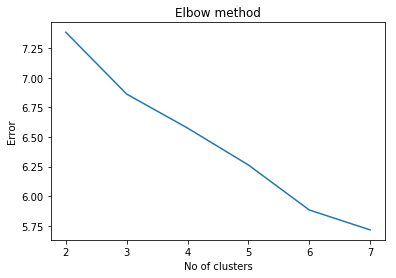

In [32]:
station_grouped_clustering = station_grouped.drop('Station', 1)
Error =[]
for i in range(2, 8):
    kmeans = KMeans(n_clusters = i).fit(station_grouped_clustering)
    kmeans.fit(station_grouped_clustering)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(2, 8), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [33]:
# set number of clusters
kclusters = 6
station_grouped_clustering = station_grouped.drop('Station', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(station_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 1, 4, 4, 4, 4, 4, 3, 4])

In [34]:
# add clustering labels
station_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
station_merged = df_MRT
# merge station_grouped with station_data to add latitude/longitude for each station
station_merged = station_merged.join(station_venues_sorted.set_index('Station'), on='station_name')
station_merged.head() # check dataframe

,station_name,type,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jurong East,MRT,1.333207,103.742308,4,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Food Court,Shopping Mall,Steakhouse,Korean Restaurant,Multiplex,Department Store,Café
1,Bukit Batok,MRT,1.349069,103.749596,1,Coffee Shop,Fast Food Restaurant,Food Court,Chinese Restaurant,Frozen Yogurt Shop,Bus Station,Bowling Alley,Multiplex,Café,Shopping Mall
2,Bukit Gombak,MRT,1.359043,103.751863,0,Food Court,Vegetarian / Vegan Restaurant,Stadium,Ice Cream Shop,Steakhouse,Supermarket,Flea Market,Fast Food Restaurant,Chinese Restaurant,Sandwich Place
3,Choa Chu Kang,MRT,1.385417,103.744316,1,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Smoke Shop,Gym,Thai Restaurant,Sushi Restaurant,Supermarket,Bubble Tea Shop,Food Court
4,Yew Tee,MRT,1.397383,103.747523,1,Fast Food Restaurant,Japanese Restaurant,Pool,Electronics Store,Café,Sandwich Place,Coffee Shop,Food Court,Diner,Shopping Mall


In [35]:
#cast cluster labels as integer for map
station_merged['Cluster Labels'] = station_merged['Cluster Labels'].astype(int)

In [36]:
#visualise results
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(station_merged['lat'], station_merged['lng'], station_merged['station_name'], station_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster - 1],
    fill=True,
    fill_color=rainbow[cluster - 1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters


In [56]:
#Examine the clusters - cluster 1
station_merged.loc[station_merged['Cluster Labels'] == 0, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bukit Gombak,Food Court,Vegetarian / Vegan Restaurant,Stadium,Ice Cream Shop,Steakhouse,Supermarket,Flea Market,Fast Food Restaurant,Chinese Restaurant,Sandwich Place
31,Pioneer,Gym / Fitness Center,Bus Station,Stadium,Convenience Store,Pool,Fast Food Restaurant,Shopping Mall,Food Court,Snack Place,Bus Line
33,Lakeside,Food Court,Convenience Store,Trail,Snack Place,Food & Drink Shop,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop
79,MacPherson,Food Court,Climbing Gym,Basketball Court,Hobby Shop,BBQ Joint,Thai Restaurant,Food Truck,Asian Restaurant,Bakery,Office


In [58]:
#Examine the clusters - cluster 2
station_merged.loc[station_merged['Cluster Labels'] == 1, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bukit Batok,Coffee Shop,Fast Food Restaurant,Food Court,Chinese Restaurant,Frozen Yogurt Shop,Bus Station,Bowling Alley,Multiplex,Café,Shopping Mall
3,Choa Chu Kang,Coffee Shop,Fast Food Restaurant,Ice Cream Shop,Smoke Shop,Gym,Thai Restaurant,Sushi Restaurant,Supermarket,Bubble Tea Shop,Food Court
4,Yew Tee,Fast Food Restaurant,Japanese Restaurant,Pool,Electronics Store,Café,Sandwich Place,Coffee Shop,Food Court,Diner,Shopping Mall
6,Marsiling,Coffee Shop,Flea Market,Steakhouse,Grocery Store,BBQ Joint,Asian Restaurant,Hainan Restaurant,Paintball Field,Track,Trail
8,Admiralty,Supermarket,Coffee Shop,Park,Sushi Restaurant,Optical Shop,Snack Place,Food Court,Food & Drink Shop,Filipino Restaurant,Fish & Chips Shop
9,Sembawang,Coffee Shop,Japanese Restaurant,Asian Restaurant,Bus Station,Supermarket,Bistro,Shopping Mall,Chinese Restaurant,Train Station,BBQ Joint
11,Khatib,Coffee Shop,Asian Restaurant,Supermarket,Food Court,Grocery Store,Shopping Mall,Bakery,Train Station,Park,Seafood Restaurant
13,Ang Mo Kio,Coffee Shop,Dessert Shop,Food Court,Supermarket,Japanese Restaurant,Bubble Tea Shop,Ramen Restaurant,Snack Place,Sushi Restaurant,Modern European Restaurant
14,Bishan,Food Court,Coffee Shop,Café,Cosmetics Shop,Supermarket,Ice Cream Shop,Chinese Restaurant,Bubble Tea Shop,Japanese Restaurant,Department Store
16,Toa Payoh,Coffee Shop,Chinese Restaurant,Snack Place,Dessert Shop,Food Court,Bubble Tea Shop,Tennis Court,Bookstore,Monument / Landmark,Supermarket


In [59]:
#Examine the clusters - cluster 3
station_merged.loc[station_merged['Cluster Labels'] == 2, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Tuas West Road,Bus Station,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand


In [60]:
#Examine the clusters - cluster 4
station_merged.loc[station_merged['Cluster Labels'] == 3, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Yio Chu Kang,Food Court,Chinese Restaurant,Gym,Dance Studio,College Auditorium,Bus Stop,Cafeteria,Fast Food Restaurant,Tennis Court,Seafood Restaurant
15,Braddell,Noodle House,Chinese Restaurant,Food Court,Café,Hakka Restaurant,Asian Restaurant,Seafood Restaurant,Fast Food Restaurant,Bakery,Thai Restaurant
18,Newton,Chinese Restaurant,Seafood Restaurant,Hotel Bar,Italian Restaurant,Gym / Fitness Center,Convenience Store,Pool,Pizza Place,Café,Food Court
34,Chinese Garden,Chinese Restaurant,Coffee Shop,Bus Station,Train Station,Café,Pizza Place,Asian Restaurant,Food Court,Indian Restaurant,Food Truck
38,Commonwealth,Chinese Restaurant,Indian Restaurant,Asian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Noodle House,Diner,Fast Food Restaurant,Paper / Office Supplies Store,Food Court
39,Queenstown,Noodle House,Food Court,Chinese Restaurant,BBQ Joint,Stadium,Spa,Food & Drink Shop,Café,Seafood Restaurant,Train Station
40,Redhill,Chinese Restaurant,Coffee Shop,Hainan Restaurant,Gym,Malay Restaurant,Food Court,Pool,Train Station,Park,Flea Market
41,Tiong Bahru,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Bakery,Food Court,Café,Japanese Restaurant,Bar,Fast Food Restaurant,Supermarket
46,Kallang,Food Court,Thai Restaurant,BBQ Joint,Snack Place,Hostel,Soup Place,Chinese Restaurant,Supermarket,Noodle House,Seafood Restaurant
47,Aljunied,Chinese Restaurant,Noodle House,Asian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Bus Station,Indian Restaurant,Dim Sum Restaurant,Food Court,Seafood Restaurant


In [61]:
#Examine the clusters - cluster 5
station_merged.loc[station_merged['Cluster Labels'] == 4, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jurong East,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Food Court,Shopping Mall,Steakhouse,Korean Restaurant,Multiplex,Department Store,Café
5,Kranji,Bus Line,Noodle House,Go Kart Track,Dessert Shop,Stadium,Racetrack,Food Stand,Fish & Chips Shop,Flea Market,Flower Shop
7,Woodlands,Japanese Restaurant,Café,Coffee Shop,Clothing Store,Shopping Mall,Chinese Restaurant,Asian Restaurant,Frozen Yogurt Shop,Fast Food Restaurant,Electronics Store
10,Yishun,Chinese Restaurant,Food Court,Supermarket,Park,Coffee Shop,Italian Restaurant,Hainan Restaurant,Fried Chicken Joint,Bubble Tea Shop,Café
17,Novena,Café,Coffee Shop,Japanese Restaurant,Hotel,Chinese Restaurant,Italian Restaurant,Ramen Restaurant,Dessert Shop,Sandwich Place,Restaurant
19,Orchard,Boutique,Sushi Restaurant,Bakery,Hotel,Shopping Mall,Chinese Restaurant,Bubble Tea Shop,Café,Cosmetics Shop,Coffee Shop
20,Somerset,Shopping Mall,Hotel,Japanese Restaurant,Clothing Store,Café,Chinese Restaurant,Ice Cream Shop,Ramen Restaurant,Supermarket,Bar
21,Dhoby Ghaut,Café,Hotel,History Museum,Japanese Restaurant,Park,Arts & Crafts Store,Museum,Sandwich Place,Karaoke Bar,Restaurant
22,City Hall,Hotel,Café,Cocktail Bar,Bakery,Coffee Shop,French Restaurant,Lounge,Japanese Restaurant,Shopping Mall,Juice Bar
23,Raffles Place,Café,Japanese Restaurant,Coffee Shop,Cocktail Bar,Salad Place,Gym / Fitness Center,Hotel,Chinese Restaurant,Italian Restaurant,Food Court


In [62]:
#Examine the clusters - cluster 6
station_merged.loc[station_merged['Cluster Labels'] == 5, station_merged.columns[[0] + list(range(5, station_merged.shape[1]))]]

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Little India,Indian Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,General College & University,Bakery,Playground,Music Venue,Restaurant,Hotel,Motel


In [63]:
#group by station and find number of venue category of each type
stn_grp = station_venues.groupby(['Station', 'Venue_Category']).size()
stn_grp

Station    Venue_Category               
Admiralty  Coffee Shop                      1
           Food Court                       1
           Optical Shop                     1
           Park                             1
           Snack Place                      1
           Supermarket                      2
           Sushi Restaurant                 1
Aljunied   Asian Restaurant                 4
           BBQ Joint                        1
           Badminton Court                  1
           Basketball Court                 1
           Boarding House                   1
           Breakfast Spot                   1
           Bus Station                      2
           Café                             1
           Chinese Restaurant               5
           Coffee Shop                      3
           Convenience Store                1
           Dim Sum Restaurant               2
           Farmers Market                   1
           Food Court                  

In [64]:
#find station with max number of venue category
stn_grp.idxmax()

('Jalan Besar', 'Indian Restaurant')

In [65]:
# which indian restaurants
station_venues.query('Station == ["Jalan Besar"] and Venue_Category == ["Indian Restaurant"]')

,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
4489,Jalan Besar,1.305551,103.855443,Bismillah Biryani,1.304956,103.853602,Indian Restaurant
4495,Jalan Besar,1.305551,103.855443,Murugan Idli Shop,1.308842,103.856380,Indian Restaurant
4502,Jalan Besar,1.305551,103.855443,Azmi Restaurant,1.308256,103.853075,Indian Restaurant
4503,Jalan Besar,1.305551,103.855443,Sakunthala's Restaurant,1.306000,103.852169,Indian Restaurant
4509,Jalan Besar,1.305551,103.855443,Komala Vilas (Buffalo Rd),1.306308,103.851158,Indian Restaurant
4512,Jalan Besar,1.305551,103.855443,Khansama Tandoori Restaurant,1.308251,103.853122,Indian Restaurant
4522,Jalan Besar,1.305551,103.855443,Kailash Parbat,1.308039,103.852660,Indian Restaurant
4523,Jalan Besar,1.305551,103.855443,Lagnaa Barefoot Dining,1.306472,103.852298,Indian Restaurant
4531,Jalan Besar,1.305551,103.855443,Veeras Curry Restaurant @ Hindoo Rd,1.308650,103.853515,Indian Restaurant
4535,Jalan Besar,1.305551,103.855443,Sakunthala's Restaurant,1.309475,103.855717,Indian Restaurant


In [66]:
A = stn_grp.to_frame() # convert series object to dataframe for further analysis
A['Counts'] = A.iloc[:,-1] #rename counts as Counts column
A.head()
A=A.drop([A.columns[-2]], axis = 'columns') # remove duplicate count column
A.head()

Counts
Station   Venue_Category        
Admiralty Coffee Shop          1
          Food Court           1
          Optical Shop         1
          Park                 1
          Snack Place          1

In [67]:
Alist = A.groupby('Venue_Category')['Counts'].sum() #Sum up number for each venue category
Alist

Venue_Category
ATM                                1
Accessories Store                  4
Airport                            2
Airport Lounge                     5
American Restaurant               21
Arcade                             3
Art Gallery                       21
Art Museum                         2
Arts & Crafts Store                9
Arts & Entertainment               1
Asian Restaurant                 127
Athletics & Sports                 2
Australian Restaurant              5
BBQ Joint                         44
Baby Store                         1
Badminton Court                    1
Bagel Shop                         2
Bakery                           118
Bank                               2
Bar                               43
Basketball Court                   9
Bay                                1
Beach                              1
Bed & Breakfast                    5
Beer Bar                          16
Beer Garden                        8
Beer Store             

In [68]:
Alist.sort_values(ascending = False, inplace = True) #sort venue category in descending order
Top_10 = Alist.head(10) #find top 10 venue category
Top_10

Venue_Category
Coffee Shop             245
Chinese Restaurant      236
Café                    218
Food Court              182
Japanese Restaurant     175
Hotel                   136
Asian Restaurant        127
Indian Restaurant       121
Bakery                  118
Fast Food Restaurant     98
Name: Counts, dtype: int64

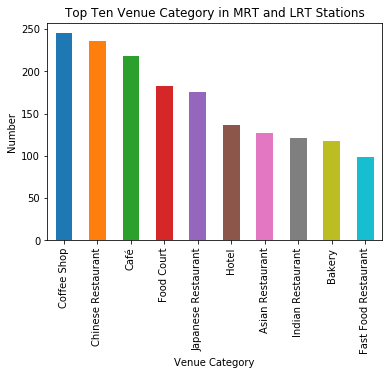

In [69]:
# plot Bar graph
import matplotlib as mpl
import matplotlib.pyplot as plt

Top_10.plot(kind = 'bar')

plt.title('Top Ten Venue Category in MRT and LRT Stations')
plt.xlabel('Venue Category')
plt.ylabel('Number')
plt.show()

In [70]:
#group by station and find number of venue of each type
stn_grp2 = station_venues.groupby(['Station', 'Venue']).size()
stn_grp2

Station    Venue                                          
Admiralty  Admiralty Optical                                  1
           Edo Sushi @ Sunplaza                               1
           Kampung Admiralty Hawker Centre                    1
           Mr Bean                                            1
           NTUC FairPrice                                     1
           NTUC Fairprice                                     1
           Starbucks                                          1
           Woodlands Admiral Garden                           1
Aljunied   7-Eleven                                           1
           Aikido Shinju-kai (Singapore) HQ 心柔会本部道场           1
           Aljunied MRT Station (EW9)                         1
           Builders At Sims                                   1
           Bus Stop 80231 (Blk 59)                            1
           Bus Stop 80239 (opp Blk 59)                        1
           Ci Hang Western & Chinese Vegetari

In [71]:
stn_grp2.idxmax() #Find venue with max number and the corresponding station

('Downtown', 'Starbucks')

In [72]:
#detailed analysis on Downtown Starbucks -get new df containing all Starbucks outlets at Downtown Station
Downtown_df = station_venues.loc[(station_venues['Station']=='Downtown') & (station_venues['Venue']=='Starbucks'),['Station', 'Station_Latitude', 'Station_Longitude','Venue','Venue_Latitude', 'Venue_Longitude' ]] 
Downtown_df

,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude
4110,Downtown,1.27949,103.852802,Starbucks,1.279335,103.854128
4142,Downtown,1.27949,103.852802,Starbucks,1.277949,103.850985
4161,Downtown,1.27949,103.852802,Starbucks,1.276988,103.852458
4176,Downtown,1.27949,103.852802,Starbucks,1.279422,103.854494


In [73]:
#Plot locations of these Starbucks
#display map with locations of Starbucks
#get downtown latitude, longitude

d_latitude = 1.27949 # station latitude value
d_longitude = 103.852802 # station longitude value

#display map centered on downtown station
downtown_map = folium.Map(location=[d_latitude, d_longitude], zoom_start=17)

#add circle marker on Downtown station
folium.features.CircleMarker(
    [d_latitude, d_longitude],
    radius=10,
    popup='Downtown',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(downtown_map)

for lat, lng, label in zip(Downtown_df.Venue_Latitude, Downtown_df.Venue_Longitude, Downtown_df.Venue):
    folium.features.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    fill=True,
    color='blue',
    fill_color='blue',
    fill_opacity=0.6
    ).add_to(downtown_map)
    
# display map
downtown_map

In [74]:
#find atm locations
ATM_df = station_venues.loc[(station_venues['Venue_Category']=='ATM'),['Station', 'Station_Latitude', 'Station_Longitude','Venue_Category', 'Venue','Venue_Latitude', 'Venue_Longitude' ]]
ATM_df

,Station,Station_Latitude,Station_Longitude,Venue_Category,Venue,Venue_Latitude,Venue_Longitude
1400,Commonwealth,1.302439,103.798326,ATM,POSB ATM,1.300509,103.801128


In [55]:
#End